<img src='letscodebr_cover.jpeg' align='left' width=100%/>

# Ada Tech [DS-PY-004] Técnicas de Programação I (PY) Aulas 4 e 5 : GeoPandas - Resolução do Exercício 5.

## CheckPoint GeoPandas

## Conjuntos de dados

Na prática de aula de hoje, usaremos um **conjunto de propriedades** que a imobiliária [Properati](https://www.properati.com.ar/) tem à venda. O interessante é que aos dados clássicos da propriedade (valor, superfície, vizinhança, tipo de propriedade), adiciona-se a posição geoespacial através de sua latitude e longitude.

Por outro lado, vamos considerar as **estações de metrô**, onde também aparecem o nome e a linha a que pertence, e também, obviamente, seus dados de posição geográfica.

## Exercício

Começamos lendo os dois conjuntos de dados em um `dataframe` e os transformamos em um `GeoDataFrame`. É o tipo de dado que o `GeoPandas` necessita para realizar operações com dados geoespaciais.

Então vamos *calcular a distância* de cada propriedade até o obelisco de Buenos Aires, e isso será registrado em uma nova coluna. Faremos um cálculo para ver se existe alguma relação entre essa distância e o preço do imóvel.

Finalmente desenharemos uma linha geométrica com todas as estações de metrô de uma linha, e faremos um gráfico sobre a cidade.

Importamos as bibliotecas de que vamos precisar:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import shapely # gera as figuras geométricas
import descartes # relaciona shapely com matplotlib
import pyproj # projeções. Transformação de Coordenadas

### Parte 1 - Arquivo de Propriedades

Vamos ler os dados do arquivo "../Data/Real_State_Properati.csv" em um `DataFrame` do pandas com o método [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), instanciando o objeto `df_prop`.

**Nota**: os dados são separados por tabulações. O parâmetro [`sep = '\ t'`](https://www.ti-enxame.com/pt/python/o-que-impressao-...-sep-t-significa/1045309866/) deve ser usado.

In [2]:
data_location = "../Data/Real_State_Properati.csv"

df_prop = pd.read_csv(data_location, sep = '\t')

#### Tomamos uma amostra de 5 elementos

As colunas do conjunto de dados são:

- `property_type`: Tipo de Propriedade. - `object`
- `place_name`: Bairro de Buenos Aires. - `object`
- `country_name`: Nome do país. Fixo 'Argentina'. - `object`
- `state_name`: Província ou Estado. Fixo 'Capital Federal'. - `object`
- `lat`: Latitude da posição geoespacial da propriedade. - `float64`
- `lon`: Longitude da posição geoespacial da propriedade. - `float64`
- `price`: Preço da propriedade. - `float64`
- `currency`: Moeda usada para o valor da propriedade. - `object`
- `surface_total_in_m2`: Área da propriedade. - `float64`

In [3]:
#list(df_prop['place_name'].unique())
#list(df_prop['state_name'].unique())

#len(list(df_prop['place_name'].unique()))

In [4]:
df_prop.sample(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
4104,apartment,Caballito,Argentina,Capital Federal,-34.623068,-58.441252,240000.0,USD,100.0
10271,apartment,Liniers,Argentina,Capital Federal,-34.641418,-58.511550,255000.0,USD,135.0
9626,house,Palermo,Argentina,Capital Federal,-34.595453,-58.418756,580000.0,USD,300.0
10996,apartment,Barrio Norte,Argentina,Capital Federal,-34.593491,-58.405342,280000.0,USD,132.0
1257,store,Puerto Madero,Argentina,Capital Federal,-34.617719,-58.362056,3600000.0,USD,714.0


In [5]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


#### Transforme o DataFrame em um GeoDataFrame

Para gerar um `GeoDataFrame`, precisamos adicionar uma nova coluna contendo uma forma geométrica às colunas do `DataFrame`. Nesse caso, um ponto, que é gerado a partir de latitude e longitude.

Recomenda-se que a nova coluna seja nomeada `geometry`. O método [`geopandas.points_from_xy()`](https://geopandas.org/docs/reference/api/geopandas.points_from_xy.html) define o tipo **ponto**, ao inserirmos primeiro a **longitude** e a **latitude**.

In [6]:
geometria = gpd.points_from_xy(df_prop['lon'], 
                               df_prop['lat']
                              )

In [7]:
geometria[0 : 2]

<GeometryArray>
[<POINT (-58.509 -34.662)>, <POINT (-58.523 -34.652)>]
Length: 2, dtype: geometry

In [8]:
geo_prop = gpd.GeoDataFrame(df_prop, 
                            geometry = geometria
                           )

In [9]:
type(geo_prop)

geopandas.geodataframe.GeoDataFrame

In [10]:
geo_prop.loc[ : 4, ['geometry', 'lat', 'lon', 'property_type', 'place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


### Parte 2 - Arquivo da estação de metrô

Vamos ler os dados do arquivo "../Data/estaciones-de-subte.csv" em um `DataFrame` do pandas com o método [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). Vamos instanciar o objeto `df_subte`.

**Nota**: Os dados são separados por vírgulas. O parâmetro `sep = ','` deve ser usado.

In [11]:
data_location = "../Data/metro-BA.csv"

df_subte = pd.read_csv(data_location, sep = ',')

#### Consultamos os primeiros $10$ registros

As colunas do conjunto de dados são:

- `lon`: Longitude da posição geoespacial da estação de metrô. - `float64`
- `lat`: Latitude da posição geoespacial da estação de metrô. - `float64
- `id`:  Eu iria. Número sequencial. - `float64
- `est`: Nome da estação de metrô. - `object`
- `lin`: A linha de metrô à qual a estação pertence. - `object`

In [12]:
df_subte.head(10)
#df_subte.info()

,lon,lat,id,est,lin
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COLÓN,D
8,-58.407161,-34.591628,9.0,AGÜERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


#### Transforme o DataFrame em um GeoDataFrame

Para gerar um `GeoDataFrame`, precisamos adicionar uma nova coluna contendo uma forma geométrica às colunas do `DataFrame`. Nesse caso, um ponto, que é gerado a partir de latitude e longitude.

Recomenda-se que a nova coluna seja nomeada `geometry`. O método [`geopandas.points_from_xy()`](https://geopandas.org/docs/reference/api/geopandas.points_from_xy.html) define o tipo **ponto**, ao inserirmos primeiro a **longitude** e a **latitude**.

In [13]:
geometria = gpd.points_from_xy(df_subte['lon'], df_subte['lat'])

In [14]:
geo_subte = gpd.GeoDataFrame(df_subte, geometry = geometria)

In [15]:
type(geo_subte)

geopandas.geodataframe.GeoDataFrame

### Parte 3 - Cálculo da distância

Vamos calcular a distância de cada propriedade ao obelisco de Buenos Aires, e a registraremos em uma nova coluna.

<img src='img/Obelisco_de_BA_2008.jpeg' align='left' width=50%/>

Primeiro, precisamos representar a localização geográfica do Obelisco de Buenos Aires. Fazemos isso usando a forma geométrica `Point` e as coordenadas do lugar.

In [16]:
from shapely.geometry import Point

ponto_obelisco_p = Point(-58.381555, -34.605425)

In [17]:
type(ponto_obelisco_p)

shapely.geometry.point.Point

Já o método que calcula a distância entre dois pontos, [`geopy.distance.geodesic`](https://geopy.readthedocs.io/en/stable/#geopy.distance.geodesic), precisa representar a localização geográfica do Obelisco de Buenos Aires por uma tupla.

In [18]:
ponto_obelisco = (-58.381555, -34.605425)

In [19]:
type(ponto_obelisco)

tuple

Agora podemos adicionar a nova coluna com a distância entre o ponto do obelisco e o ponto de cada propriedade (em metros). Vamos chamá-lo de `obelisk_distance`.

**Uma iteração** deve ser gerada no índice de `geo_prop`:

Ajuda:
```python
for i in geo_prop.index:
    geo_prop.loc[i, 'distance_obelisk'] = Calculo da distância entre o obelisco e cada propriedade.
```
    
O [cálculo da distância](https://geopy.readthedocs.io/en/stable/#module-geopy.distance) é realizado com o método [`geopy.distance.geodesic()`](https://geopy.readthedocs.io/en/stable/#geopy.distance.geodesic), discutido anteriormente.

Também com a instrução: 

```python 
geo_prop.loc[i, 'geometry'].X 
``` 

obtemos a coordenada de comprimento da distância. Deve terminar com `.meters` para indicar a distância em metros.

In [20]:
geo_prop.index

RangeIndex(start=0, stop=17223, step=1)

In [21]:
import geopy.distance

for i in geo_prop.index:
    geo_prop.loc[i, 'distance_obelisk'] = geopy.distance.geodesic(ponto_obelisco,
                  (geo_prop.loc[i, 'geometry'].x ,geo_prop.loc[i, 'geometry'].y)
                                                                   ).meters

/Users/rudineycasali/Documents/Project_Ada_Tech/venv_Ada/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [22]:
geo_prop.loc[:4, ['distance_obelisk', 'geometry', 'lat', 'lon','property_type', 'place_name']]

,distance_obelisk,geometry,lat,lon,property_type,place_name
0,14555.078219,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,15988.570648,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,13651.907067,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


É interessante encontrar **valores extremos** na distância calculada, os `outliers`. Cálculos estatísticos podem nos confundir. Para isso, vamos classificar o `GeoDataFrame` `geo_prop` pela coluna `distance_obelisk` em ordem decrescente. E veja se nos primeiros valores encontramos distâncias que apresentam um valor extremo em relação aos demais.

In [23]:
geo_prop.sort_values(by = "distance_obelisk", 
                     ascending = False).head(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distance_obelisk
4202,apartment,Mataderos,Argentina,Capital Federal,-38.416097,-63.616672,45000.0,USD,70.0,POINT (-63.61667 -38.41610),618443.386395
3689,apartment,Belgrano,Argentina,Capital Federal,-34.578678,-58.544722,85000.0,USD,38.0,POINT (-58.54472 -34.57868),18241.418749
10749,apartment,Almagro,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
10557,apartment,Palermo,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
3808,apartment,Saavedra,Argentina,Capital Federal,-34.577168,-58.538654,931457.0,USD,38.0,POINT (-58.53865 -34.57717),17576.152416


In [24]:
geo_prop["distance_obelisk"].max()

618443.3863949322

O primeiro registro tem a distância errada, que é gerada a partir dos dados de comprimento errados. Melhor removê-lo.

Para fazer isso, procuramos as propriedades que têm uma `distância_obelisco` maior que $19.000~$m e as eliminamos:

- Procuramos os valores de índice que representam essas propriedades:

In [25]:
indice = geo_prop[geo_prop.distance_obelisk > 19000].index

indice

Index([4202], dtype='int64')

Verificamos ordenando novamente pela coluna `obelisk_distance` em ordem decrescente.

In [26]:
geo_prop.drop(indice, inplace = True)

In [27]:
geo_prop.sort_values(by = "distance_obelisk", 
                     ascending = False
                    ).head(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distance_obelisk
3689,apartment,Belgrano,Argentina,Capital Federal,-34.578678,-58.544722,85000.0,USD,38.0,POINT (-58.54472 -34.57868),18241.418749
10557,apartment,Palermo,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
10749,apartment,Almagro,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
3789,apartment,Caballito,Argentina,Capital Federal,-34.577168,-58.538654,589700.0,USD,30.0,POINT (-58.53865 -34.57717),17576.152416
3734,apartment,Caballito,Argentina,Capital Federal,-34.577168,-58.538654,229000.0,USD,136.0,POINT (-58.53865 -34.57717),17576.152416


E agora podemos fazer um histograma sobre as distâncias.

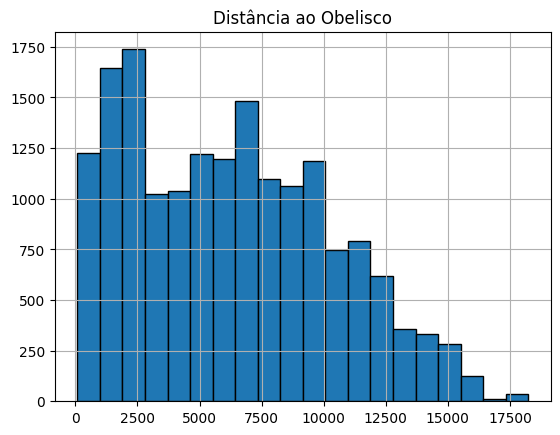

<Figure size 640x480 with 0 Axes>

In [28]:
plt.title('Distância ao Obelisco')

plt.hist(geo_prop["distance_obelisk"], 
         bins = 20, 
         alpha = 1, 
         edgecolor = 'black', 
         linewidth = 1
        )

plt.grid(True)
plt.show()
plt.clf() 

### Parte 4 - Linha conectando as estações de metrô

Vamos fazer uma linha geométrica com as estações de metrô da linha H e representá-la graficamente sobre a cidade.

<div>
    <div class = "mapa">
        <img src='img/metro_BA.jpg' alt="Elementos geométricos" width=80% height=90%>
    </div>
</div>

Vemos os primeiros registros do `GeoDataFrame` `geo_subte`.

In [29]:
geo_subte.head(4)

,lon,lat,id,est,lin,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)


Primeiro vamos selecionar apenas as estações na linha H, e salvar a seleção na variável `geo_subte_h`.

In [30]:
geo_subte_h = geo_subte.loc[geo_subte['lin'] == 'H', : ]

In [31]:
geo_subte_h

,lon,lat,id,est,lin,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
84,-58.397216,-34.587462,85.0,LAS HERAS,H,POINT (-58.39722 -34.58746)


Como mostra o desenho, a linha vai de Norte a Sul (ou Sul a Norte). Como as estações devem estar alinhadas para que a linha saia corretamente, podemos usar a coluna `lat` para ordená-las; `lat` é a latitude de cada estação. Vamos aplicar o método [`pandas.DataFrame.sort_values()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) para realizar o ordenamento.

In [32]:
geo_subte_h = geo_subte_h.sort_values(by = 'lat')

In [33]:
geo_subte_h

,lon,lat,id,est,lin,geometry
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,POINT (-58.40238 -34.59453)


Para simplificar a codificação, manteremos apenas os dados geográficos de cada estação. Geramos uma `GeoSeries` com a coluna geométrica de `geo_subte_h`. E o chamamos de `geo_subte_h_geometry`.

In [34]:
geo_subte_h_geometry = geo_subte_h["geometry"]

In [35]:
type(geo_subte_h_geometry)

geopandas.geoseries.GeoSeries

Agora criamos as linhas que conectam as estações de metrô. Cada linha é formada por **dois pontos**. Portanto, temos que pegar o primeiro e o segundo pontos do `Geoserie` e aplicar o método [`shapely.geometry.LineString()`](https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html#linestring) a eles. Em seguida, continuamos com o segundo e o terceiro, e assim por diante.

Primeiro instanciamos uma lista onde salvaremos cada linha e a chamaremos de `line_h`. Deve ter comprimento igual ao número de estações menos $1$, ou seja, comprimento $11$.

In [36]:
longitud_linea = len(geo_subte_h_geometry) - 1
linea_h = list(range(longitud_linea))

In [37]:
len(linea_h)

11

Agora podemos criar as linhas e salvá-las na lista.

Uma iteração deve ser gerada para atravessar a `GeoSerie` `geo_subte_h_geometry`.

```python
para i no intervalo (line_length):
     linea_h [i] = Eu crio a linha entre o elemento i e o elemento i + 1
```
    
O cálculo é realizado com o método [`shapely.geometry.LineString()`](https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html#linestring) da [biblioteca shapely](https://shapely.readthedocs.io/en/stable/manual.html), discutido anteriormente.

In [38]:
from shapely.geometry import LineString

for i in range(longitud_linea): 
    linea_h[i] = LineString([geo_subte_h_geometry.iloc[i], geo_subte_h_geometry.iloc[i + 1]])

In [39]:
linea_h

[<LINESTRING (-58.412 -34.641, -58.406 -34.638)>,
 <LINESTRING (-58.406 -34.638, -58.399 -34.636)>,
 <LINESTRING (-58.399 -34.636, -58.401 -34.629)>,
 <LINESTRING (-58.401 -34.629, -58.402 -34.623)>,
 <LINESTRING (-58.402 -34.623, -58.405 -34.615)>,
 <LINESTRING (-58.405 -34.615, -58.406 -34.609)>,
 <LINESTRING (-58.406 -34.609, -58.405 -34.604)>,
 <LINESTRING (-58.405 -34.604, -58.404 -34.598)>,
 <LINESTRING (-58.404 -34.598, -58.402 -34.595)>,
 <LINESTRING (-58.402 -34.595, -58.397 -34.587)>,
 <LINESTRING (-58.397 -34.587, -58.391 -34.583)>]

Agora vamos representar graficamente as linhas em um mapa com os bairros de Buenos Aires. Vamos ler os dados do arquivo `../Data/Neighborhoods.csv` em um `DataFrame` do pandas com o método [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). Vamos chamá-lo de `df_bairros`.

In [40]:
df_bairros = pd.read_csv("../Data/Neighborhoods.csv", 
                         encoding = 'latin1'
                        )

In [41]:
df_bairros.head(3)

,WKT,NEIGHBORHOOD,COMMUNE,PERIMETER,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06


In [42]:
type(df_bairros)

pandas.core.frame.DataFrame

E então geramos um `GeoDataFrame` das vizinhanças do `Dataframe`. Neste caso, a coluna `WKT` já contém uma forma geométrica do tipo Polígono, que representa o contorno de cada vizinhança. Mas em um formato `WKT`, não permite gerar um `GeoDataFrame`. Portanto, temos que convertê-lo em um formato de `geometry`.

In [43]:
import shapely.wkt

df_bairros["WKT"] = df_bairros["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(df_bairros, geometry = 'WKT')

In [44]:
geo_barrios.dtypes

WKT             geometry
NEIGHBORHOOD      object
COMMUNE          float64
PERIMETER        float64
AREA             float64
dtype: object

Por outro lado, precisamos representar graficamente as linhas para gerar um `Geoserie`, em que cada elemento é composto por dois pontos e a linha entre eles.

In [45]:
linea_h_geo = list(range(longitud_linea))

for i in range(longitud_linea): 
    linea_h_geo[i] = gpd.GeoSeries([geo_subte_h_geometry.iloc[i], 
                                    geo_subte_h_geometry.iloc[i + 1], 
                                    linea_h[i]
                                   ]
                                  )

In [46]:
linea_h_geo[ : 2]

[0                          POINT (-58.41239 -34.64127)
 1                          POINT (-58.40579 -34.63841)
 2    LINESTRING (-58.41239 -34.64127, -58.40579 -34...
 dtype: geometry,
 0                          POINT (-58.40579 -34.63841)
 1                          POINT (-58.39893 -34.63575)
 2    LINESTRING (-58.40579 -34.63841, -58.39893 -34...
 dtype: geometry]

Com o método `plot()`, geramos o gráfico:

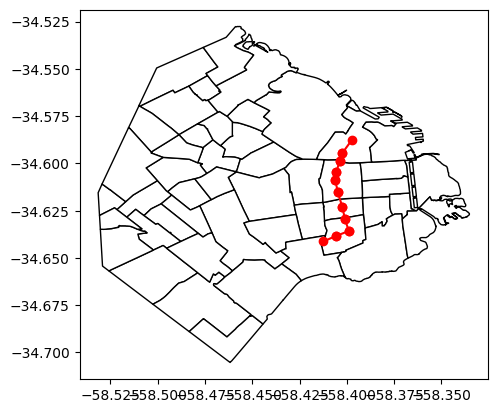

In [47]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_barrios.plot(ax = ax, 
                 color = 'white', 
                 edgecolor = 'black'
                )

for i in range(len(geo_subte_h_geometry) - 2): 
    linea_h_geo[i].plot(ax = ax, 
                        color = 'red'
                       )

plt.show();